In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [3]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [4]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')


# lr_X_dim1 = torch.ones((167, 160, 32))
# lr_X_dim3 = torch.ones((167, 160, 32))
# hr_X_dim1 = torch.ones((167, 268, 32))
# hr_X_dim3 = torch.ones((167, 268, 32))
# lr_X_dim1_test = torch.ones((167, 160, 32))
# hr_X_dim3_test = torch.ones((167, 268, 32))


In [5]:
print(lr_X_dim1.shape)
print(lr_X_dim1.shape)



torch.Size([167, 160, 32])
torch.Size([167, 160, 32])


# Model Layers

In [6]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [7]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [8]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.25):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        #new_A = F.relu(custom_activation(new_A))
        new_A = F.tanh(F.relu(new_A))
        # new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

def custom_activation(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-5*x))

    

In [9]:
class embedder(torch.nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super(embedder, self).__init__()
        self.omega1 = nn.Parameter(torch.randn((hidden, in_dim), device=DEVICE))
        self.beta1 = nn.Parameter(torch.zeros((hidden, 1), device=DEVICE))
        self.omega2 = nn.Parameter(torch.randn((out_dim, hidden), device=DEVICE))
        self.beta2 = nn.Parameter(torch.zeros((out_dim, 1), device=DEVICE))

    def forward(self, A):
        X = F.elu(self.beta1 + self.omega1 @ A)
        X = F.elu(self.beta2 + self.omega2 @ X)
        
        return torch.transpose(X,-1,-2)


In [10]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls, embedding_dims_ls=None):
        super().__init__()

        
        if embedding_dims_ls:
            self.has_embedding_layer = True
            assert len(embedding_dims_ls) == 3, 'Embedding dim list must be exactly 3'
            assert channels_ls[0] == embedding_dims_ls[-1], f'Last embedding dim must match first channel dim. Received {channels_ls[0]} and {embedding_dims_ls[-1]}'
            self.embedder = embedder(embedding_dims_ls[0], embedding_dims_ls[1], embedding_dims_ls[2])

        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        
        if self.has_embedding_layer:
            X = self.embedder(A)
            Y = X

        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [11]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [12]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [13]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls,  epoch, a=0.95, b=0.5, c=0.1): #modified
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)

    alpha = (1 - np.exp(-c * epoch)) * (a - b) + b #modified

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss #modified
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [14]:
import gc

def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    #epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        #if (epoch + 1) % 10 == 0:
        #    epoch_weight = # modified


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):
            gc.collect()
            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            gc.collect()
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], epoch=epoch)
            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            gc.collect()
            torch.cuda.empty_cache()

            # for printing loss only
            # non_neg = up_adj_ls[-1].detach().cpu()
            # non_neg[non_neg < 0] = 0
            torch.cuda.empty_cache()
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            gc.collect()
            torch.cuda.empty_cache()
        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        if epoch % 1 == 0:
            print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst.loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [15]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=8)
channels_ls = [32, 64]
embedding_dims_ls_up = [160,8,32]
embedding_dims_ls_down = [268,8,32]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls, embedding_dims_ls_up).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls, embedding_dims_ls_down).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


4251912

In [16]:
gc.collect()
up_changer, down_changer, loss_log = train(200, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None)

100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


ep 0: down loss = 0.1934967122294686, up loss = 0.17187012054703452, reconst.loss = 0.28764093735001306, down adj mae = 0.2675269869240848, up adj mae = 0.3010187501257116


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 1: down loss = 0.16884192282503302, up loss = 0.1433982808481563, reconst.loss = 0.25732975520870904, down adj mae = 0.2384862561117519, up adj mae = 0.27184742960062896


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 2: down loss = 0.14510390162467957, up loss = 0.11847098442641171, reconst.loss = 0.22925995696674695, down adj mae = 0.21827828884124756, up adj mae = 0.23276090215552936


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 3: down loss = 0.12981577285311438, up loss = 0.1013850373300639, reconst.loss = 0.20585053888234225, down adj mae = 0.21710496192628687, up adj mae = 0.21430129625580527


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 4: down loss = 0.1108493676239794, up loss = 0.08395681868899953, reconst.loss = 0.18721004372293298, down adj mae = 0.20161248066208579, up adj mae = 0.19245333563197742


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 5: down loss = 0.09611944921992042, up loss = 0.07447235083038156, reconst.loss = 0.1765693873167038, down adj mae = 0.19567900896072388, up adj mae = 0.18389985913580115


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 6: down loss = 0.08135352825576608, up loss = 0.06425560198046944, reconst.loss = 0.16955825280059467, down adj mae = 0.18699742582711307, up adj mae = 0.17497338219122452


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 7: down loss = 0.06935015320777893, up loss = 0.05919492583383213, reconst.loss = 0.16459545357660813, down adj mae = 0.18467661332000385, up adj mae = 0.172451528635892


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 8: down loss = 0.06041548976844007, up loss = 0.054542081261223015, reconst.loss = 0.16360819881612604, down adj mae = 0.17116570608182388, up adj mae = 0.16375617412003604


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 9: down loss = 0.04927274483171376, up loss = 0.04763112183321606, reconst.loss = 0.15822879021817987, down adj mae = 0.16638021171092987, up adj mae = 0.15885605324398389


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 10: down loss = 0.04266975955529646, up loss = 0.04488688910549337, reconst.loss = 0.15492308952591635, down adj mae = 0.1607247983867472, up adj mae = 0.1572740457274697


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 11: down loss = 0.03751480545509945, up loss = 0.044020877981727775, reconst.loss = 0.15394610979340292, down adj mae = 0.15565072135491806, up adj mae = 0.15251045470887964


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 12: down loss = 0.03457793813537468, up loss = 0.04231398417191072, reconst.loss = 0.1528053812005303, down adj mae = 0.16235653514211829, up adj mae = 0.15663527629592203


  9%|▉         | 1/11 [00:01<00:14,  1.44s/it]

In [22]:
loss_log['up_end_mae'][-1]

0.1254234713586894

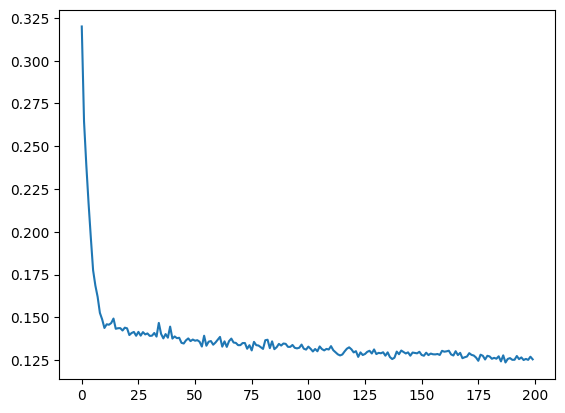

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [27]:
torch.save(up_changer.state_dict(), 'submission_files/moritz_deep6/model_new_scheduler_0.95_0.1_0.1_newact.pth')

In [20]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


In [29]:
torch.save(test_predictions, 'submission_files/moritz_deep6/model_new_scheduler_0.95_0.1_0.1_newact.pt')

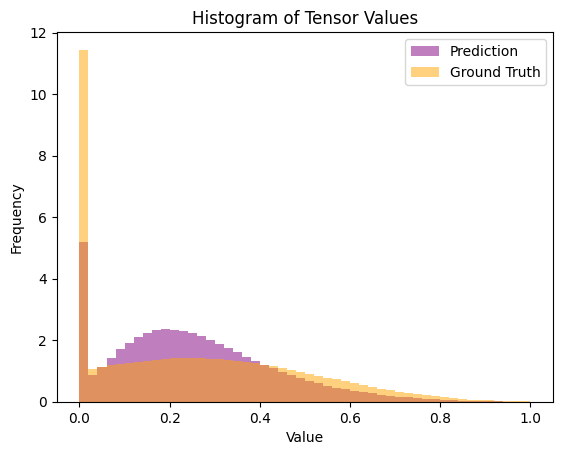

In [21]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

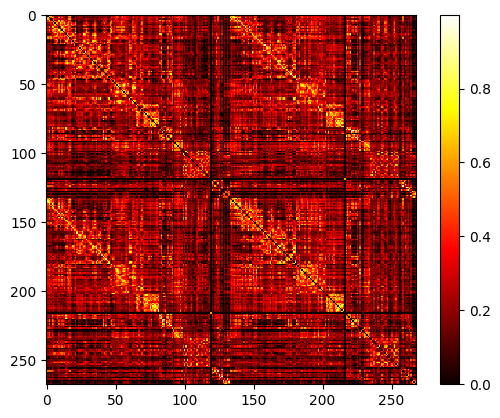

In [26]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [24]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/moritz_deep6/new_scheduler_0.95_0.5_0.1_tanhrelu.csv')

# Cross Validation

In [12]:
from evaluation_fn import evaluate_predictions
from data_preparation import generate_histogram, generate_heatmap

def validation(up_changer, testloader, val_adj_hr, histogram=False, heatmap=False, statement=None):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    if histogram:
        if statement:
            print(statement)
        else:
            print(f'Histogram for Current Fold')
        generate_histogram(val_predictions.cpu(), val_adj_hr.cpu())
    if heatmap:
        if statement:
            print(statement)
        else:
            print(f'First Difference Heatmap for Current Fold')
        generate_heatmap((val_adj_hr[0].cpu() - val_predictions[0].cpu()))

    return {'eval': evaluate_predictions(val_predictions, val_adj_hr), 'preds': val_predictions}

In [13]:
def cross_validate(epochs, early, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, channels_ls = [32, 64], histogram=False, heatmap=False):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=num_steps)
        channels_ls = channels_ls

        up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))
        
        losses = None
        completed = 0
        remaining = epochs
        val_metrics = {}
        if early>0 and early<epochs:
            up_changer, down_changer, losses = train(epochs-early, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer)

            testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
            val_metrics[f'{epochs-early}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap, statement=f'Currrent Fold after {epochs-early}')
            completed = epochs-early
            remaining = early

        up_changer, down_changer, losses = train(remaining, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=completed, loss_log=losses)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics[f'{epochs}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap)
        val_metrics['losses'] = losses


        runs_results.append(val_metrics)

    return runs_results

ep 0: down loss = 0.20542784248079574, up loss = 0.17689721073423112, reconst.loss = 0.2917357385158539, down adj mae = 0.28023557577814373, up adj mae = 0.3008601026875632
ep 5: down loss = 0.1186667765889849, up loss = 0.08996828432594027, reconst.loss = 0.19326673448085785, down adj mae = 0.200643105166299, up adj mae = 0.19940794791494096
ep 10: down loss = 0.09603335389069148, up loss = 0.07120798528194427, reconst.loss = 0.16777990332671575, down adj mae = 0.19407629115240915, up adj mae = 0.17528733611106873
ep 15: down loss = 0.06417143610971314, up loss = 0.04896345628159387, reconst.loss = 0.148720383644104, down adj mae = 0.17378063925674983, up adj mae = 0.15315520763397217
ep 20: down loss = 0.05338169315031597, up loss = 0.04240606139813151, reconst.loss = 0.1454591921397618, down adj mae = 0.162979713508061, up adj mae = 0.14283521473407745
ep 25: down loss = 0.03819405606814793, up loss = 0.035724910242216926, reconst.loss = 0.14097283567701066, down adj mae = 0.1591136

100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Currrent Fold after 150


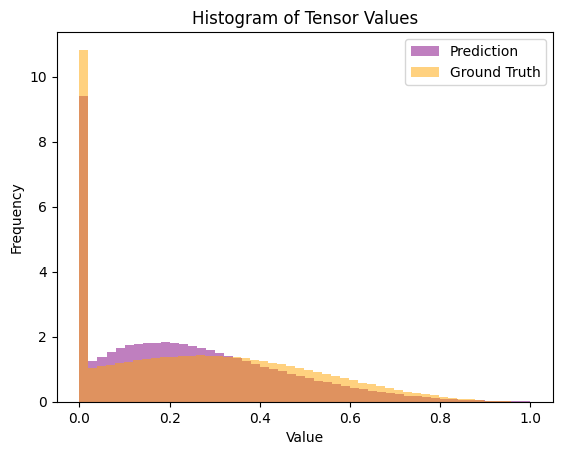

Currrent Fold after 150


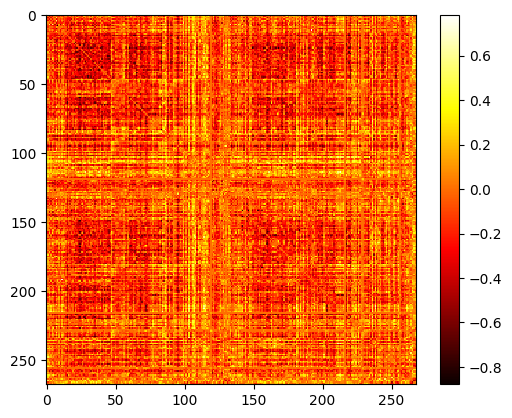

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [15:26<00:00, 16.54s/it]


MAE:  0.16116904
PCC:  0.524993344378733
Jensen-Shannon Distance:  0.32995154984221897
Average MAE betweenness centrality: 0.020401149462141492
Average MAE eigenvector centrality: 0.015226380737286627
Average MAE PageRank centrality: 0.0006773713541569766
ep 0: down loss = 0.006380146968045405, up loss = 0.0158438521570393, reconst.loss = 0.13057847108159745, down adj mae = 0.13134667383772985, up adj mae = 0.13174007407256536
ep 5: down loss = 0.005506261651005063, up loss = 0.016638871282339096, reconst.loss = 0.12987329704420908, down adj mae = 0.13006924731390818, up adj mae = 0.12858788881983077
ep 10: down loss = 0.005310260890317815, up loss = 0.017472519805388793, reconst.loss = 0.1296737545302936, down adj mae = 0.13405350063528335, up adj mae = 0.13207562267780304
ep 15: down loss = 0.004891299509576389, up loss = 0.01821261564535754, reconst.loss = 0.12933587921517237, down adj mae = 0.13138913469655172, up adj mae = 0.1293073839374951
ep 20: down loss = 0.004766956038240876

100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Histogram for Current Fold


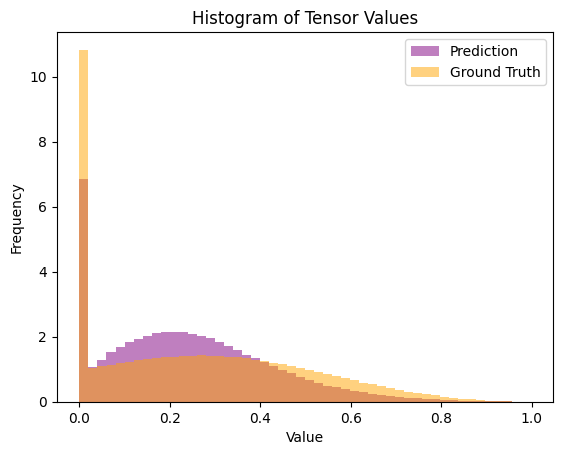

First Difference Heatmap for Current Fold


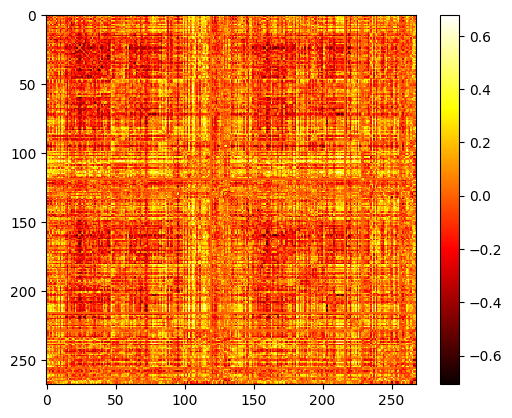

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [15:36<00:00, 16.73s/it]


MAE:  0.1471955
PCC:  0.5847776188096059
Jensen-Shannon Distance:  0.3029359454081041
Average MAE betweenness centrality: 0.02033582614930753
Average MAE eigenvector centrality: 0.015033138612969213
Average MAE PageRank centrality: 0.0006342795577355632
ep 0: down loss = 0.20171732561928885, up loss = 0.177174910902977, reconst.loss = 0.2940806746482849, down adj mae = 0.26427251952035086, up adj mae = 0.29943519830703735
ep 5: down loss = 0.12228867624487195, up loss = 0.0928933737533433, reconst.loss = 0.1970305187361581, down adj mae = 0.21298239912305558, up adj mae = 0.20412572579724447
ep 10: down loss = 0.08422857310090746, up loss = 0.06346333133322853, reconst.loss = 0.16519363863127573, down adj mae = 0.18093752435275487, up adj mae = 0.1673998428242547
ep 15: down loss = 0.0678270576255662, up loss = 0.05191797975982938, reconst.loss = 0.15575117298534938, down adj mae = 0.16331608380590165, up adj mae = 0.1527087198836463
ep 20: down loss = 0.04531081659453256, up loss = 0.

100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Currrent Fold after 150


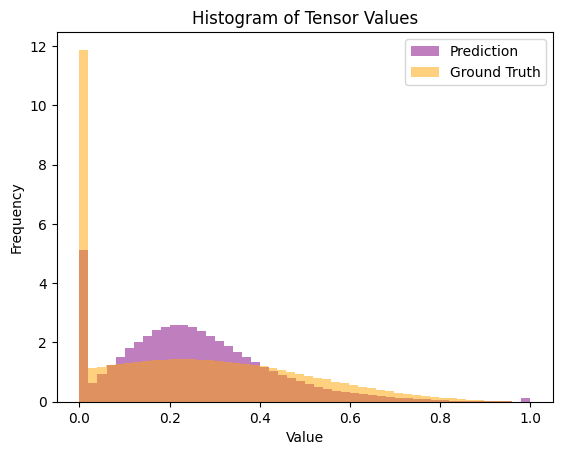

Currrent Fold after 150


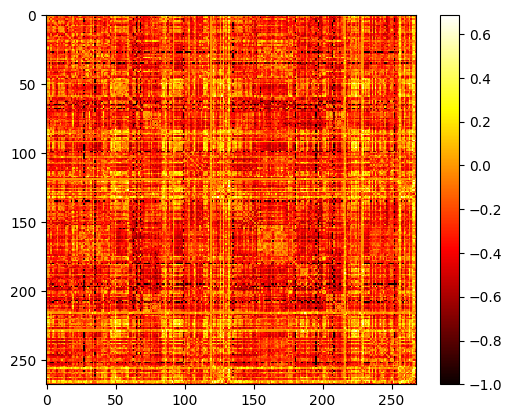

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [16:13<00:00, 17.38s/it]


MAE:  0.14550929
PCC:  0.5612022052846123
Jensen-Shannon Distance:  0.3094253802459974
Average MAE betweenness centrality: 0.020319128494315022
Average MAE eigenvector centrality: 0.01406087745453914
Average MAE PageRank centrality: 0.0005991217722949627
ep 0: down loss = 0.0067262908975992885, up loss = 0.015865199533956393, reconst.loss = 0.13134912720748357, down adj mae = 0.13276036935193197, up adj mae = 0.12918143293687276
ep 5: down loss = 0.005569386162928173, up loss = 0.01671991204576833, reconst.loss = 0.13118124433926173, down adj mae = 0.13619842060974666, up adj mae = 0.132082143000194
ep 10: down loss = 0.005365864839404821, up loss = 0.01760112919977733, reconst.loss = 0.13083278281348093, down adj mae = 0.1323296938623701, up adj mae = 0.1313498690724373
ep 15: down loss = 0.004995083768985101, up loss = 0.01817721181682178, reconst.loss = 0.1301210650375911, down adj mae = 0.13111339722360885, up adj mae = 0.12725156545639038
ep 20: down loss = 0.004829667708171266, u

100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Histogram for Current Fold


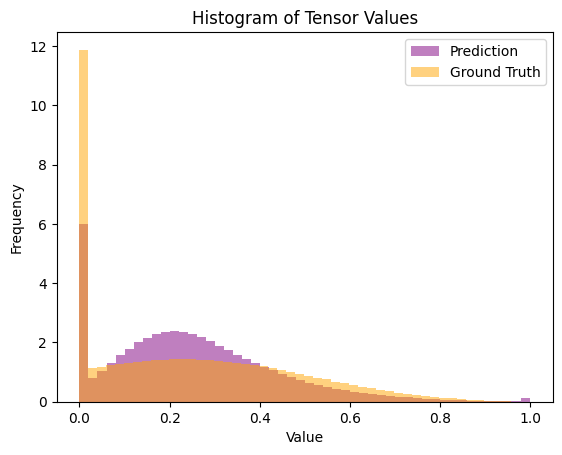

First Difference Heatmap for Current Fold


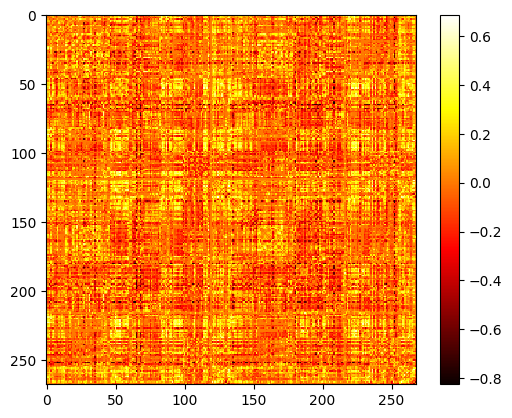

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [15:26<00:00, 16.54s/it]


MAE:  0.15038282
PCC:  0.5386630841000459
Jensen-Shannon Distance:  0.3183711699190621
Average MAE betweenness centrality: 0.02020935440647569
Average MAE eigenvector centrality: 0.01430102632801868
Average MAE PageRank centrality: 0.0006213854753756093
ep 0: down loss = 0.20112047025135585, up loss = 0.174918104495321, reconst.loss = 0.2913154661655426, down adj mae = 0.2667226770094463, up adj mae = 0.29520135692187716
ep 5: down loss = 0.12778487588678086, up loss = 0.09736089089087077, reconst.loss = 0.20078169235161372, down adj mae = 0.20746498022760665, up adj mae = 0.20317019735063827
ep 10: down loss = 0.08336876119886126, up loss = 0.06226235681346485, reconst.loss = 0.163847987140928, down adj mae = 0.1855943500995636, up adj mae = 0.16260278012071336
ep 15: down loss = 0.06049914977380207, up loss = 0.047092964074441364, reconst.loss = 0.1497550287417003, down adj mae = 0.16627104580402374, up adj mae = 0.14933871371405466
ep 20: down loss = 0.049766160015548976, up loss = 

100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Currrent Fold after 150


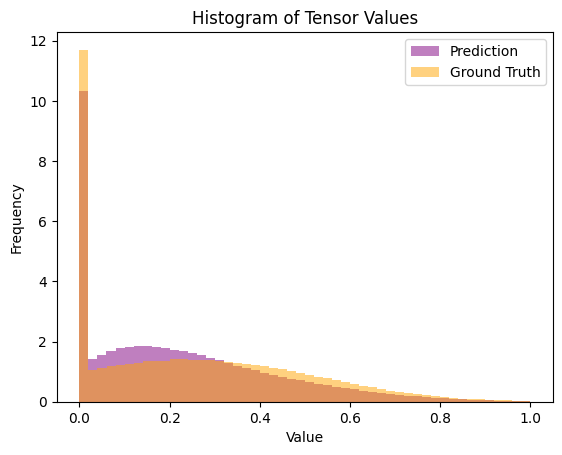

Currrent Fold after 150


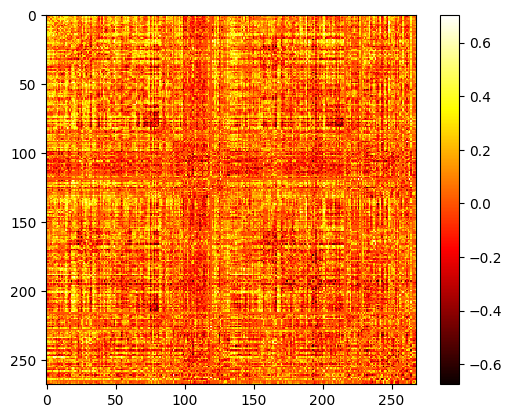

Evaluating Predictions (Can be Slow): 100%|██████████| 55/55 [14:50<00:00, 16.18s/it]


MAE:  0.16812076
PCC:  0.4847609286930924
Jensen-Shannon Distance:  0.35237276165059483
Average MAE betweenness centrality: 0.020686356783517337
Average MAE eigenvector centrality: 0.015590752230226889
Average MAE PageRank centrality: 0.000697045560464763
ep 0: down loss = 0.006355592382273504, up loss = 0.015552881839019912, reconst.loss = 0.12869427459580557, down adj mae = 0.13116962994847978, up adj mae = 0.1292926562683923
ep 5: down loss = 0.0055428689478763515, up loss = 0.016229661447661265, reconst.loss = 0.12822251234735763, down adj mae = 0.13137693916048324, up adj mae = 0.12805742983307158
ep 10: down loss = 0.005346913156764848, up loss = 0.01721616674746786, reconst.loss = 0.1282224612576621, down adj mae = 0.13230975823743002, up adj mae = 0.13032318013054983
ep 15: down loss = 0.005320605688861438, up loss = 0.01786910928785801, reconst.loss = 0.12806240575654165, down adj mae = 0.13297508231231145, up adj mae = 0.1293427954827036
ep 20: down loss = 0.0047937461973301,

100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Histogram for Current Fold


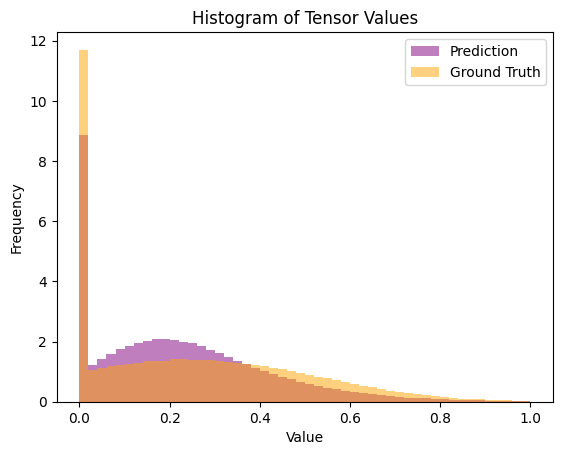

First Difference Heatmap for Current Fold


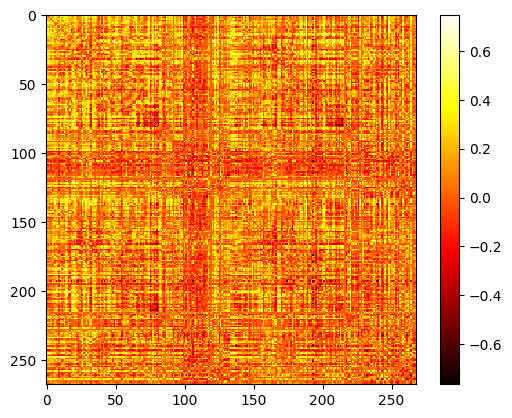

Evaluating Predictions (Can be Slow): 100%|██████████| 55/55 [15:09<00:00, 16.54s/it]

MAE:  0.15672809
PCC:  0.5218283993452018
Jensen-Shannon Distance:  0.3342464489580575
Average MAE betweenness centrality: 0.020988766566760686
Average MAE eigenvector centrality: 0.015640490622717346
Average MAE PageRank centrality: 0.0006961932007344329


In [14]:
import gc

#a=0.95

# del up_changer
# del down_changer
# del test_predictions
gc.collect()

torch.cuda.empty_cache()

results = cross_validate(200,50,16, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=12, histogram=True, heatmap=True)

In [22]:
torch.save(results, 'submission_files/moritz_deep4/results_cv_0.95_0.5_0.002.pt')

[0.174918104495321, 0.14589284786156245, 0.13297852448054723, 0.1157514431646892, 0.11879795576844897, 0.09736089089087077, 0.09180118249995368, 0.07724575911249433, 0.07172081300190516, 0.06377226699675832, 0.06226235681346485, 0.05623753368854523, 0.05499196265425001, 0.049235813851867406, 0.04681469979030745, 0.047092964074441364, 0.04726385910596166, 0.04551862818854196, 0.04462029252733503, 0.044704081756728034, 0.041797696479729245, 0.04611229630453246, 0.04122467126165118, 0.03694302908011845, 0.038037094686712535, 0.038510719048125405, 0.036916004227740426, 0.034729884671313424, 0.03297500471983637, 0.03236655651458672, 0.030656782111951282, 0.03342040787850108, 0.03392957363809858, 0.034473877134067674, 0.031896590920431275, 0.02974186385316508, 0.03049686098737376, 0.029269389808177948, 0.029803482283438956, 0.031253284375582426, 0.030472446765218462, 0.030452542273061618, 0.02947984396346978, 0.030058702720063075, 0.030580019312245504, 0.02869851514697075, 0.0283137179378952

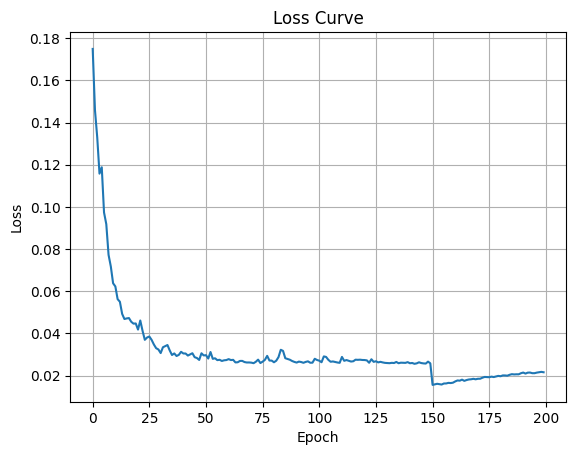

In [21]:
import matplotlib.pyplot as plt

losses_fold1 = results[2]['losses']['up']

print(losses_fold1)

plt.plot(losses_fold1)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
